In [2]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils.discrim_attack import HideAttackExp
from utils.data import load_Ford_A, transform_Ford_A, MyDataset
from models.models import LSTM_net

from utils.attacks import fgsm_disc_attack, fgsm_attack, fgsm_reg_attack

# Discriminator model

In [71]:
def load_experiment(model_name='fgsm_attack_eps=0.03_nsteps=10', device='cpu'):
    with open(fr'results/Ford_A/Regular/Discriminator_pickle/{model_name}/0.pickle', 'rb') as f:
        experiment = pickle.load(f)

    return experiment

In [72]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
experiment = load_experiment(model_name='fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10', device=device)

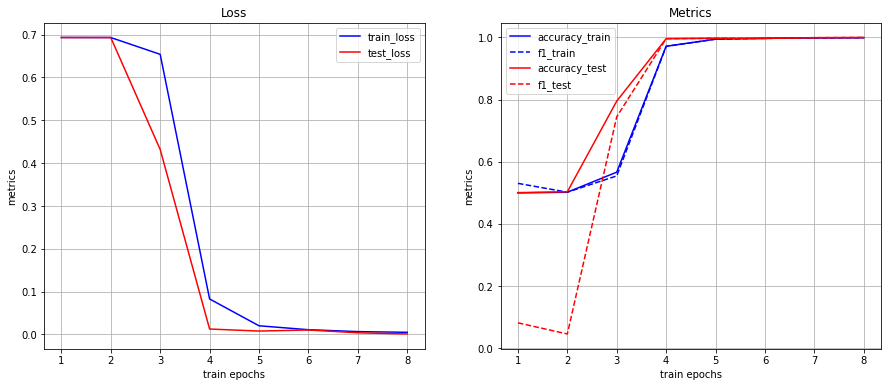

In [95]:
train_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['train']['loss']][:8]
test_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['test']['loss']][:8]

train_accuracy = experiment.dict_logging['train']['accuracy'][:8]
train_f1 = experiment.dict_logging['train']['f1'][:8]
test_accuracy = experiment.dict_logging['test']['accuracy'][:8]
test_f1 = experiment.dict_logging['test']['f1'][:8]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(np.arange(len(test_accuracy))+1, train_loss, c='blue', label ='train_loss')
plt.plot(np.arange(len(test_accuracy))+1, test_loss, c='red', label ='test_loss')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.subplot(1, 2, 2)
plt.title("Metrics")

plt.plot(np.arange(len(train_accuracy))+1, train_accuracy, c='blue', label ='accuracy_train')
plt.plot(np.arange(len(train_accuracy))+1, train_f1, c='blue', linestyle='--', label ='f1_train')
plt.plot(np.arange(len(test_accuracy))+1, test_accuracy, c='red', label ='accuracy_test')
plt.plot(np.arange(len(test_accuracy))+1, test_f1, c='red', linestyle='--', label ='f1_test')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.show()

# Data loading

In [119]:
df_loc_test = pd.read_csv(f'results/Ford_A/Regular_Disc/Diff_disc_2/TEST_aa_res_Ford_A_0_alpha=1.csv', index_col=0)
df_loc_orig = pd.read_csv(f'results/Ford_A/Regular_Disc/Diff_disc_2/aa_res_Ford_A_0_alpha=1.csv', index_col=0)

,n steps,ACC,ROC AUC,PR AUC,HID,eps
0,0,0.000000,0.000000,0.0,6.195190e-06,0.0
1,0,0.000000,0.000000,0.0,-5.612436e-05,0.0
2,0,0.000000,0.000000,0.0,6.851390e-06,0.0
3,0,0.000000,0.000000,0.0,6.092294e-05,0.0
4,0,0.000000,0.000000,0.0,-7.084640e-05,0.0
...,...,...,...,...,...,...
46,0,-0.000152,-0.000147,0.0,7.100000e-06,0.0
47,0,-0.000530,-0.000514,0.0,1.410000e-05,0.0
48,0,-0.000152,-0.000147,0.0,-4.015000e-05,0.0
49,0,-0.000152,-0.000147,0.0,2.654000e-05,0.0


In [109]:
df_reg_disc = pd.DataFrame()

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    df_loc = pd.read_csv(f'results/Ford_A/Regular_Disc/Same_disc/aa_res_Ford_A_{0}_alpha={alpha}.csv', index_col=0)
    df_loc['method_attack'] = 'reg_disc_same'
    df_loc['alpha'] = alpha

    df_reg_disc = pd.concat([df_reg_disc, df_loc])


print(df_reg_disc.shape)
df_reg_disc.head()

(1530, 8)


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000288,0.001,reg_disc_same,0.001
1,1,0.755227,0.755006,0.680578,0.000245,0.001,reg_disc_same,0.001
2,2,0.749848,0.749590,0.675103,0.000253,0.001,reg_disc_same,0.001
3,3,0.742803,0.742525,0.667921,0.000400,0.001,reg_disc_same,0.001
4,4,0.735682,0.735344,0.660880,0.000576,0.001,reg_disc_same,0.001


In [110]:
df_reg_disc_diff = pd.DataFrame()

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    df_loc = pd.read_csv(f'results/Ford_A/Regular_Disc/Diff_disc/aa_res_Ford_A_{0}_alpha={alpha}.csv', index_col=0)
    df_loc['method_attack'] = 'reg_disc_diff'
    df_loc['alpha'] = alpha

    df_reg_disc_diff = pd.concat([df_reg_disc_diff, df_loc])


print(df_reg_disc_diff.shape)
df_reg_disc_diff.head()

(1530, 8)


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000329,0.001,reg_disc_diff,0.001
1,1,0.755227,0.755006,0.680578,0.000298,0.001,reg_disc_diff,0.001
2,2,0.749848,0.749590,0.675103,0.000326,0.001,reg_disc_diff,0.001
3,3,0.742803,0.742525,0.667921,0.000367,0.001,reg_disc_diff,0.001
4,4,0.735682,0.735344,0.660880,0.000585,0.001,reg_disc_diff,0.001


In [111]:
df_reg_disc_diff_2 = pd.DataFrame()

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    df_loc = pd.read_csv(f'results/Ford_A/Regular_Disc/Diff_disc_2/aa_res_Ford_A_{0}_alpha={alpha}.csv', index_col=0)
    df_loc['method_attack'] = 'reg_disc_diff_2'
    df_loc['alpha'] = alpha

    df_reg_disc_diff_2 = pd.concat([df_reg_disc_diff_2, df_loc])


print(df_reg_disc_diff_2.shape)
df_reg_disc_diff_2.head()

(1530, 8)


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000329,0.001,reg_disc_diff_2,0.001
1,1,0.755227,0.755006,0.680578,0.000302,0.001,reg_disc_diff_2,0.001
2,2,0.749848,0.749590,0.675103,0.000339,0.001,reg_disc_diff_2,0.001
3,3,0.742803,0.742525,0.667921,0.000364,0.001,reg_disc_diff_2,0.001
4,4,0.735682,0.735344,0.660880,0.000518,0.001,reg_disc_diff_2,0.001


In [112]:
df_reg = pd.DataFrame()

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    df_loc = pd.read_csv(f'results/Ford_A/Regular/aa_res_Ford_A_{0}_alpha={alpha}.csv', index_col=0)
    df_loc['method_attack'] = 'reg'
    df_loc['alpha'] = alpha

    df_reg = pd.concat([df_reg, df_loc])


print(df_reg.shape)
df_reg.head()

(1530, 8)


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000218,0.001,reg,0.001
1,1,0.755227,0.755006,0.680578,0.000282,0.001,reg,0.001
2,2,0.749848,0.749590,0.675103,0.000294,0.001,reg,0.001
3,3,0.742803,0.742525,0.667921,0.000356,0.001,reg,0.001
4,4,0.735682,0.735344,0.660880,0.000477,0.001,reg,0.001


In [113]:
df_original = pd.read_csv(f'results/Ford_A/Original/aa_res_Ford_A_{0}_alpha=0.001.csv', index_col=0)
df_original['method_attack'] = 'original'
df_original['alpha'] = 0
df_original.head()

,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000197,0.001,original,0
1,1,0.755227,0.755006,0.680578,0.000276,0.001,original,0
2,2,0.749848,0.749590,0.675103,0.000346,0.001,original,0
3,3,0.742803,0.742525,0.667921,0.000423,0.001,original,0
4,4,0.735682,0.735344,0.660880,0.000529,0.001,original,0


In [114]:
df_res = pd.concat([df_reg_disc, df_reg_disc_diff, df_reg_disc_diff_2, df_reg, df_original])

print(df_res.shape)
df_res.head()

(6375, 8)


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000288,0.001,reg_disc_same,0.001
1,1,0.755227,0.755006,0.680578,0.000245,0.001,reg_disc_same,0.001
2,2,0.749848,0.749590,0.675103,0.000253,0.001,reg_disc_same,0.001
3,3,0.742803,0.742525,0.667921,0.000400,0.001,reg_disc_same,0.001
4,4,0.735682,0.735344,0.660880,0.000576,0.001,reg_disc_same,0.001


# Analysis

In [115]:
alpha = 10
eps = df_res.eps.unique()[1]
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.002670,0.005623,reg_disc_same,10.0
1,1,0.725985,0.725570,0.651420,0.002640,0.005623,reg_disc_same,10.0
2,2,0.690000,0.689227,0.617899,0.004319,0.005623,reg_disc_same,10.0
3,3,0.655758,0.654675,0.588094,0.011948,0.005623,reg_disc_same,10.0
4,4,0.624848,0.623474,0.563116,0.014211,0.005623,reg_disc_same,10.0
...,...,...,...,...,...,...,...,...
46,46,0.086515,0.083862,0.483864,0.999982,0.005623,original,0.0
47,47,0.084773,0.082173,0.483864,0.999986,0.005623,original,0.0
48,48,0.082045,0.079530,0.483864,0.999976,0.005623,original,0.0
49,49,0.080000,0.077543,0.483940,0.999987,0.005623,original,0.0


In [116]:
print(eps)

0.0056234132519034


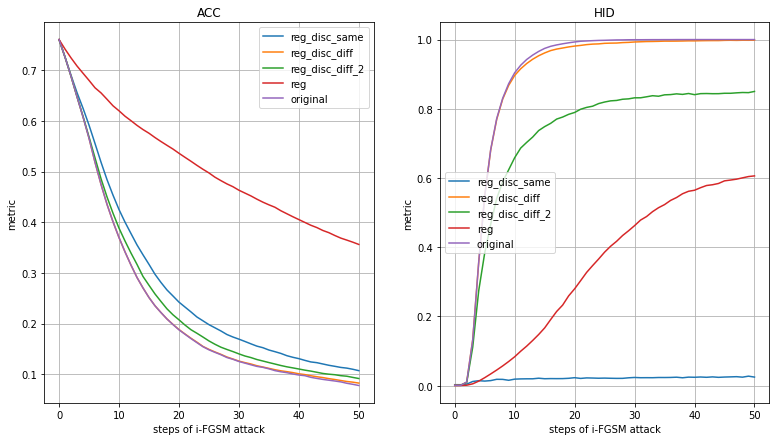

In [117]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


## Hidennes of adversarial attack

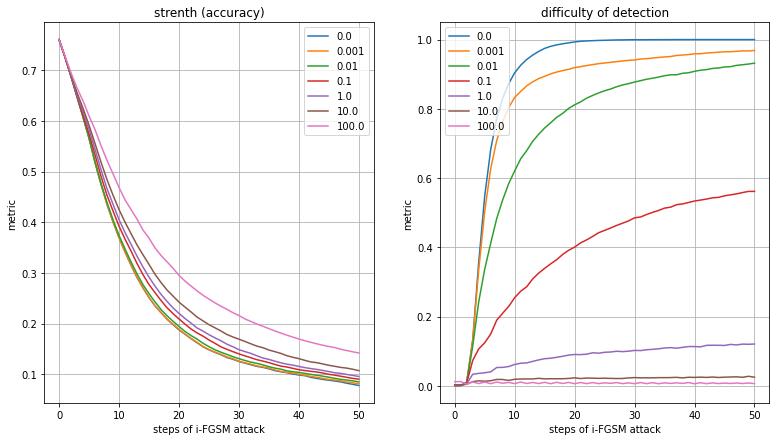

In [41]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_disc_same', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

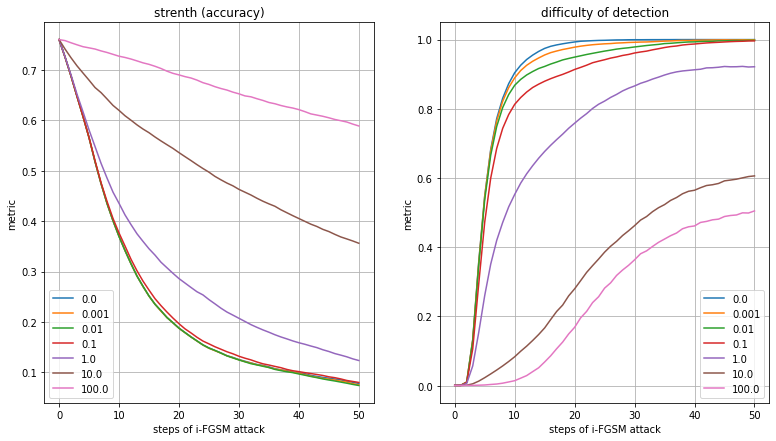

In [42]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

In [22]:
metrics = ['ACC', 'HID']


plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, alpha in enumerate(df_filter['alpha'].unique()):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

array([0.00562341, 0.17782794])